In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import agama
# working units: 1 Msun, 1 kpc, 1 km/s
agama.setUnits(length=1, velocity=1, mass=1)

from astropy.constants import G
from astropy import units as u
G = G.to(u.kpc*(u.km/u.s)**2/u.Msun)

import time as timer

In [2]:
G.to(u.kpc**3/u.Msun/u.Gyr**2)

<Quantity 4.49850215e-06 kpc3 / (solMass Gyr2)>

In [3]:
# Define a function to compute the density normalization
def compute_densitynorm(M, Rs, p, q):
    # Simplified example of computing C based on the scale radius and axis ratios
    # In practice, this can be more complex and may involve integrals over the profile
    C = (4 * np.pi * Rs**3) / (p * q)
    densitynorm = M / C
    return densitynorm

# Define a function to compute angular velocity
def omega(xv):
    
    r      = (xv[:3]**2).sum()**0.5 *u.kpc # kpc
    L_vect = np.cross(xv[:3]*u.kpc , xv[3:]*u.km/u.s )
    L      = np.linalg.norm(L_vect)

    return (L/r**2).to(1/u.Gyr)

# Define a function to compute the tidal radius of a satellite
def get_tidal_radius(xv, logm, pot):

    r  = (xv[:3]**2).sum()**0.5 # kpc

    d2Phi_dx2, d2Phi_dy2, d2Phi_dz2 = -pot.forceDeriv(xv[:3])[1][:3]

    d2Phi_dr2 = d2Phi_dx2*(xv[0]/r)**2 + d2Phi_dy2*(xv[1]/r)**2 + d2Phi_dz2*(xv[2]/r)**2 
    
    rt = (G.to(u.kpc**3/u.Msun/u.Gyr**2) * 10**logm*u.Msun/ (omega(xv)**2 - d2Phi_dr2/u.Gyr**2))**(1/3)
    return rt.value # kpc

def sigma_Plum(r, logm, rs):
    return np.sqrt(G.value * 10**logm / (6 * np.sqrt(r**2+rs**2) ) ) # km/s

In [4]:
logM, Rs = 12., 15. 
p, q = 0.9, 0.8

logm, rs = 8., 1.  

x0, y0, z0 = -40., 0., 0.  
vx0, vy0, vz0 = 0., 100., 0. 

tend = 5. # Gyr

rot_mat = np.identity(3)

In [6]:
# Compute densitynorm
densitynorm = compute_densitynorm(10**logM, Rs, p, q)

# Set host potential
# pot_host = agama.Potential(type='NFW', mass=10**logM, scaleradius=Rs)
pot_host = agama.Potential(type='Spheroid', densitynorm=densitynorm, scaleradius=Rs, gamma=1, alpha=1, beta=3, axisRatioY=p, axisRatioZ=q)

# Set satellite potential
pot_sat  = agama.Potential(type='Plummer',  mass=10**logm, scaleradius=rs)

# initial displacement
r_center = np.array([x0, y0, z0, vx0, vy0, vz0])

In [7]:
dt = 0.001 # 10 Myr
t, xv = agama.orbit(ic=r_center, potential=pot_host, time=tend, timestart=0, trajsize=int(tend/dt)+1, verbose=False)
dt = t[1] - t[0]

In [8]:
xv.shape

(5001, 6)

100%|██████████| 5001/5001 [03:20<00:00, 24.93it/s]


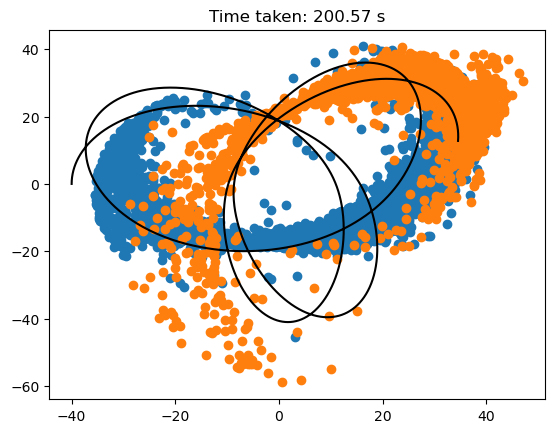

In [124]:
a = timer.time()
xv_all_leading  = np.zeros((len(t), 6))
xv_all_trailing = np.zeros((len(t), 6))
for i in tqdm(range(len(t)), leave=True):
    xv_prog  = xv[i]
    pot_sat  = agama.Potential(type='Plummer',  mass=10*logm, scaleradius=rs, center=[xv_prog[0], xv_prog[1], xv_prog[2]])
    r_tidal  = get_tidal_radius(xv_prog, logm, pot_host)
    vel_disp = sigma_Plum(r_tidal, logm, rs)

    r_prog = (xv_prog[:3]**2).sum()**0.5
    theta  = np.arccos(xv_prog[2]/r_prog)
    phi    = np.arctan2(xv_prog[1], xv_prog[0])

    r_leading = r_prog - r_tidal
    xv_leading = np.zeros(6)
    xv_leading[0] = r_leading * np.sin(theta) * np.cos(phi)
    xv_leading[1] = r_leading * np.sin(theta) * np.sin(phi)
    xv_leading[2] = r_leading * np.cos(theta)
    xv_leading[3:] = np.random.normal(xv_prog[3:], vel_disp, 3)

    r_trailing = r_prog + r_tidal
    xv_trailing = np.zeros(6)
    xv_trailing[0] = r_trailing * np.sin(theta) * np.cos(phi)
    xv_trailing[1] = r_trailing * np.sin(theta) * np.sin(phi)
    xv_trailing[2] = r_trailing * np.cos(theta)
    xv_trailing[3:] = np.random.normal(xv_prog[3:], vel_disp, 3)

    xv_all_leading[i]  = xv_leading
    xv_all_trailing[i] = xv_trailing
    pot_tot = agama.Potential(potential=[pot_host, pot_sat])

    xv_all_leading[:i+1]  = np.vstack(agama.orbit(ic=xv_all_leading[:i+1], potential=pot_tot, time=dt, timestart=0, trajsize=1, verbose=False)[:, 1])
    xv_all_trailing[:i+1] = np.vstack(agama.orbit(ic=xv_all_trailing[:i+1], potential=pot_tot, time=dt, timestart=0, trajsize=1, verbose=False)[:, 1])
b = timer.time()
plt.title('Time taken: %.2f s' % (b-a))
plt.scatter(xv_all_leading[:,0], xv_all_leading[:,1])
plt.scatter(xv_all_trailing[:,0], xv_all_trailing[:,1])
plt.plot(xv[:, 0], xv[:, 1], c='k')